In [24]:
import os 
import sys
# fix this later!
# sys.path.insert(0, '/home/sumry2023_cqx3/hypergraph_scattering')
from hypgs.models.hyper_scattering_net import HSN
from hypgs import DATA_DIR
import dhg 
import torch 
import torch.optim as optim

from typing import Tuple, Optional 
from dhg.random import set_seed
from dhg import Graph
from dhg.models import GCN
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator
import time
import torch.nn.functional as F
import torch.nn as nn
import random
from tqdm import trange
import matplotlib.pyplot as plt

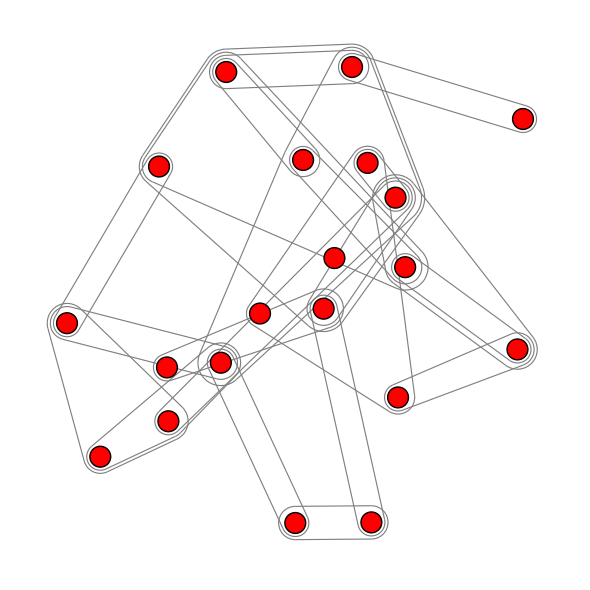

In [2]:
num_v = 20
num_e = 22
hg = dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first')
hg.draw()

In [23]:
hg.e[0]

[(4, 9),
 (2, 17, 18),
 (3, 13, 19),
 (1, 6),
 (17, 18),
 (10, 12),
 (0, 17),
 (18, 19),
 (6, 7, 17),
 (1, 15, 16),
 (0, 7),
 (8, 14),
 (2, 3, 4, 6, 7, 12),
 (1, 14),
 (14, 15, 16),
 (4, 7),
 (8, 10),
 (2, 3),
 (11, 12),
 (2, 12),
 (2, 15),
 (0, 2, 3, 4, 14)]

In [22]:
hg.H_v2e

tensor(indices=tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,
                         3,  3,  4,  4,  4,  4,  6,  6,  6,  7,  7,  7,  7,  8,
                         8,  9, 10, 10, 11, 12, 12, 12, 12, 13, 14, 14, 14, 14,
                        15, 15, 15, 16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19],
                       [ 6, 10, 21,  3,  9, 13,  1, 12, 17, 19, 20, 21,  2, 12,
                        17, 21,  0, 12, 15, 21,  3,  8, 12,  8, 10, 12, 15, 11,
                        16,  0,  5, 16, 18,  5, 12, 18, 19,  2, 11, 13, 14, 21,
                         9, 14, 20,  9, 14,  1,  4,  6,  8,  1,  4,  7,  2,  7]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(20, 22), nnz=56, layout=torch

In [43]:
import csv
import gzip

def gen_hypg_deg_dataset(num_v, num_e, num_graphs):
    hypergraph_dataset = [dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first') for _ in range(num_graphs)]

    return hypergraph_dataset

def save_individual_hypergraphs(hypergraph_dataset, filename_prefix):
    for idx, hypergraph in enumerate(hypergraph_dataset):
        with open(f"{filename_prefix}_{idx}.ihg.tsv", 'w') as file:
            writer = csv.writer(file, delimiter='\t')
            for hyperedge in hypergraph.e[0]:
                writer.writerow(hyperedge)

def save_collection_hypergraphs(hypergraph_dataset, filename):
    with open(f"{filename}.chg.tsv", 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        for idx, hypergraph in enumerate(hypergraph_dataset):
            for hyperedge in hypergraph.e[0]:
                row = [idx] + list(hyperedge)
                writer.writerow(row)

def convert_to_one_index(hypergraph_dataset):
    # assume the nodes are zero indexed
    for hypergraph in hypergraph_dataset:
        for hyperedge_idx, hyperedge in enumerate(hypergraph.e[0]):
            # Increment each node index in the hyperedge by one
            hypergraph.e[0][hyperedge_idx] = tuple(node + 1 for node in hyperedge)
    return hypergraph_dataset

def convert_to_zero_index(hypergraph_dataset):
    # assume the nodes are one indexed
    for hypergraph in hypergraph_dataset:
        for hyperedge_idx, hyperedge in enumerate(hypergraph.e[0]):
            # Increment each node index in the hyperedge by one
            hypergraph.e[0][hyperedge_idx] = tuple(node - 1 for node in hyperedge)
    return hypergraph_dataset

filename = os.path.join(DATA_DIR, 'Synthetic', 'synthetic_hypergraphs')
num_graphs = 200
num_graphs_test = 100
num_v = 10
num_e = 20 
hypergraph_dataset = gen_hypg_deg_dataset(num_v, num_e, num_graphs)

save_collection_hypergraphs(convert_to_one_index(hypergraph_dataset), filename)


In [35]:
def save_individual_hypergraphs(hypergraph_dataset, filename_prefix):
    for idx, hypergraph in enumerate(hypergraph_dataset):
        with open(f"{filename_prefix}_{idx}.ihg.tsv", 'w') as file:
            for hyperedge in hypergraph.e[0]:
                line = '   '.join(map(str, hyperedge)) + '\n'  # Using '   ' as a delimiter
                file.write(line)

def save_collection_hypergraphs(hypergraph_dataset, filename):
    with open(f"{filename}.chg.tsv", 'w') as file:
        for idx, hypergraph in enumerate(hypergraph_dataset):
            for hyperedge in hypergraph.e[0]:
                row = [str(idx)] + list(map(str, hyperedge))
                line = '   '.join(row) + '\n'  # Using '   ' as a delimiter
                file.write(line)

filename = os.path.join(DATA_DIR, 'Synthetic', 'synthetic_hypergraphs')
num_graphs = 2
num_graphs_test = 100
num_v = 4
num_e = 3
hypergraph_dataset = gen_hypg_deg_dataset(num_v, num_e, num_graphs)

save_collection_hypergraphs(hypergraph_dataset, filename)

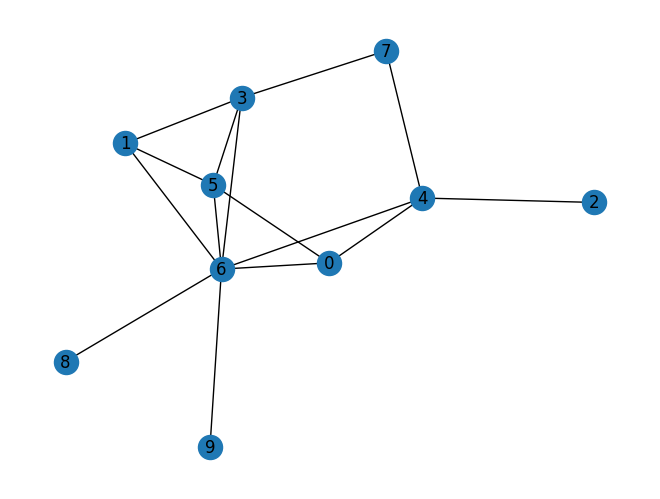

In [3]:
# visualize converting an ER graph into a hypergraph with the desired features
import torch
from torch_geometric.utils import from_networkx

import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph using NetworkX
G = nx.fast_gnp_random_graph(10, 0.3)  # Generate a random graph with 10 nodes and edge probability 0.3

# Visualize the generated graph (optional)
nx.draw(G, with_labels=True)
plt.show()

# Convert NetworkX graph to PyTorch Geometric data object
data = from_networkx(G)


In [13]:
data.edge_index.shape

torch.Size([2, 22])

In [14]:
data

Data(edge_index=[2, 22], num_nodes=10)

In [5]:
from torch_geometric.utils import to_undirected

# Assuming data.edge_index is your edge index tensor

# Convert edge_index to an undirected graph to ensure no duplicates
edge_index_undirected = to_undirected(data.edge_index)

# Transpose the edge index to get unique edges
unique_edges = edge_index_undirected.t().tolist()

# Convert to tuples of integers
edges_as_tuples = [(int(edge[0]), int(edge[1])) for edge in unique_edges]

print(edges_as_tuples)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 7), (1, 9), (2, 0), (2, 6), (3, 0), (3, 8), (4, 0), (4, 5), (4, 9), (5, 0), (5, 4), (5, 9), (6, 2), (6, 8), (6, 9), (7, 1), (7, 8), (8, 3), (8, 6), (8, 7), (9, 1), (9, 4), (9, 5), (9, 6)]


In [6]:
hg = dhg.Hypergraph(data.num_nodes, edges_as_tuples)

In [7]:
def data_to_hg(data, add_k_hop = 0, min_k_hop_size = 0):
    edge_index_undirected = to_undirected(data.edge_index)
    unique_edges = edge_index_undirected.t().tolist()

    edges_as_tuples = [(int(edge[0]), int(edge[1])) for edge in unique_edges]
    if add_k_hop:
        g = dhg.Graph(data.num_nodes, edges_as_tuples)
        hg_k_hop = dhg.Hypergraph.from_graph_kHop(g, k = add_k_hop)
        hyperedges = hg_k_hop.e 
        if min_k_hop_size > 0:
            hyperedges_filtered = [edge for edge in hyperedges[0] if len(edge) > min_k_hop_size]
            edges_as_tuples = edges_as_tuples + hyperedges_filtered
        else:
            edges_as_tuples = edges_as_tuples + hyperedges[0]
    hg = dhg.Hypergraph(data.num_nodes, edges_as_tuples)
    return hg

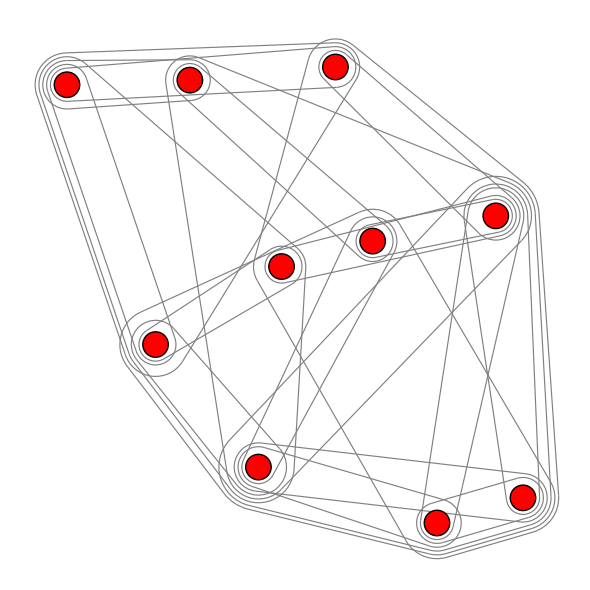

In [8]:
hg = data_to_hg(data, add_k_hop=1, min_k_hop_size = 3)
hg.draw()

In [1]:
!nvidia-smi

Fri Nov 17 13:25:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                On  | 00000000:3B:00.0 Off |                  Off |
| 33%   20C    P8               7W / 230W |      1MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

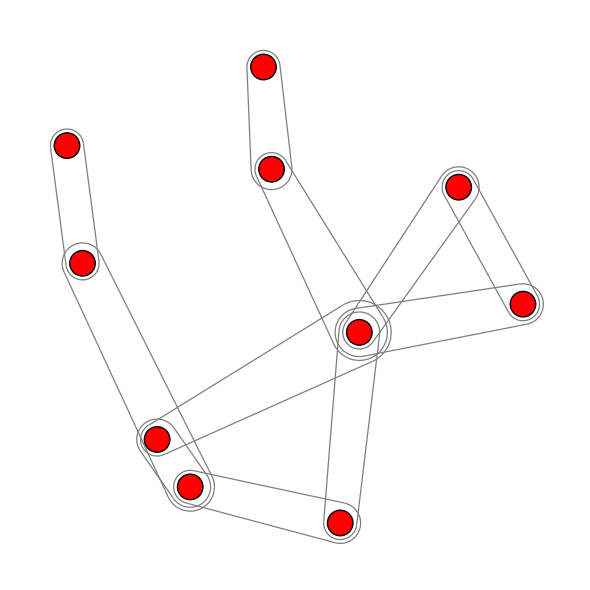

In [20]:
hg.draw()

In [ ]:
hg = dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first')


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_vertices = 15
hg = dhg.random.uniform_hypergraph_Gnp(3,num_vertices, .4).to(device)
signal_features = 2
X = torch.rand(num_vertices, signal_features).to(device)
Y = torch.zeros((hg.num_e, signal_features)).to(device)

hidden_channels = 16
out_channels = 1
net = HSN(signal_features, hidden_channels, 1).to(device)
#import pdb; pdb.set_trace()

node_pred, edge_pred = net(hg, X, Y)
node_pred.shape

torch.Size([15, 1])

In [6]:
num_v = 15; num_e = 30
hypergraph_dataset = [dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first') for _ in range(50)]


In [10]:
net = HSN(signal_features, hidden_channels, 1).to(device)
random.shuffle(hypergraph_dataset)
for hg in hypergraph_dataset:
    hg = hg.to(device)
    signal_features = 2
    X = torch.rand(num_v, signal_features).to(device)
    Y = torch.zeros((hg.num_e, signal_features)).to(device)
    node_pred, edge_pred = net(hg, X, Y)